This notebook is part of the deepcell-spots documentation: https://deepcell-spots.readthedocs.io/

# Multiplex FISH Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.feature import peak_local_max
from skimage.io import imread

from deepcell_spots.applications import Polaris
from deepcell.utils.plot_utils import create_rgb_image

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Import images and barcodes

In [2]:
# Load images
idx_fov = 215
file_name = '/data/moffit_lab/raw_tiff_stacks/fov_%d.tif'%idx_fov
im_raw = imread(file_name)[:, :, 40:-40, 40:-40] # first dim is channel: 20 spot channel + 3 extra
im_raw = np.moveaxis(im_raw, (0,1,2,3), (3,0,1,2)) # (z, x, y, channel), z can be viewed as batch
im_raw_sub = im_raw[3:4, 1040:1240, 1040:1240, :] # crop a smaller image sample (1, 200, 200, 23)
spots_image = im_raw_sub[..., :20]
nuclear_image = im_raw_sub[..., 20:21]
membrane_image = im_raw_sub[..., 22:23]
mesmer_image = np.concatenate((nuclear_image, membrane_image), axis=-1)

In [3]:
# TODO: maybe save the processed csv?
# Load barcodes
def load_barcodes():
    df_barcodes = pd.read_csv('/data/Spots_barcode_Emily/dataset_2/barcodes.csv', index_col=0)
    df_barcodes.drop('id', axis=1, inplace=True)
    df_barcodes.index.name = 'code_name'
    df_barcodes = df_barcodes.reset_index()
    df_barcodes.index += 1
    return df_barcodes

df_barcodes = load_barcodes()
r = 10
c = 2

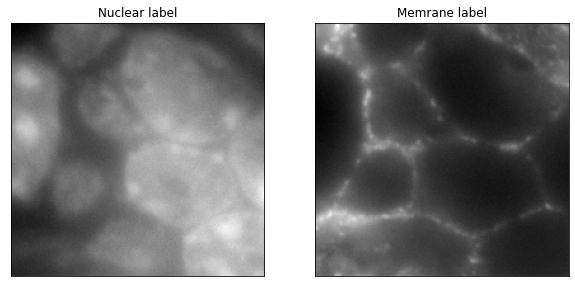

In [4]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(nuclear_image[0,...,0],cmap='gray')
ax[0].set_title('Nuclear label')
ax[1].imshow(membrane_image[0,...,0],cmap='gray')
ax[1].set_title('Memrane label')

for i in range(np.shape(ax)[0]):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

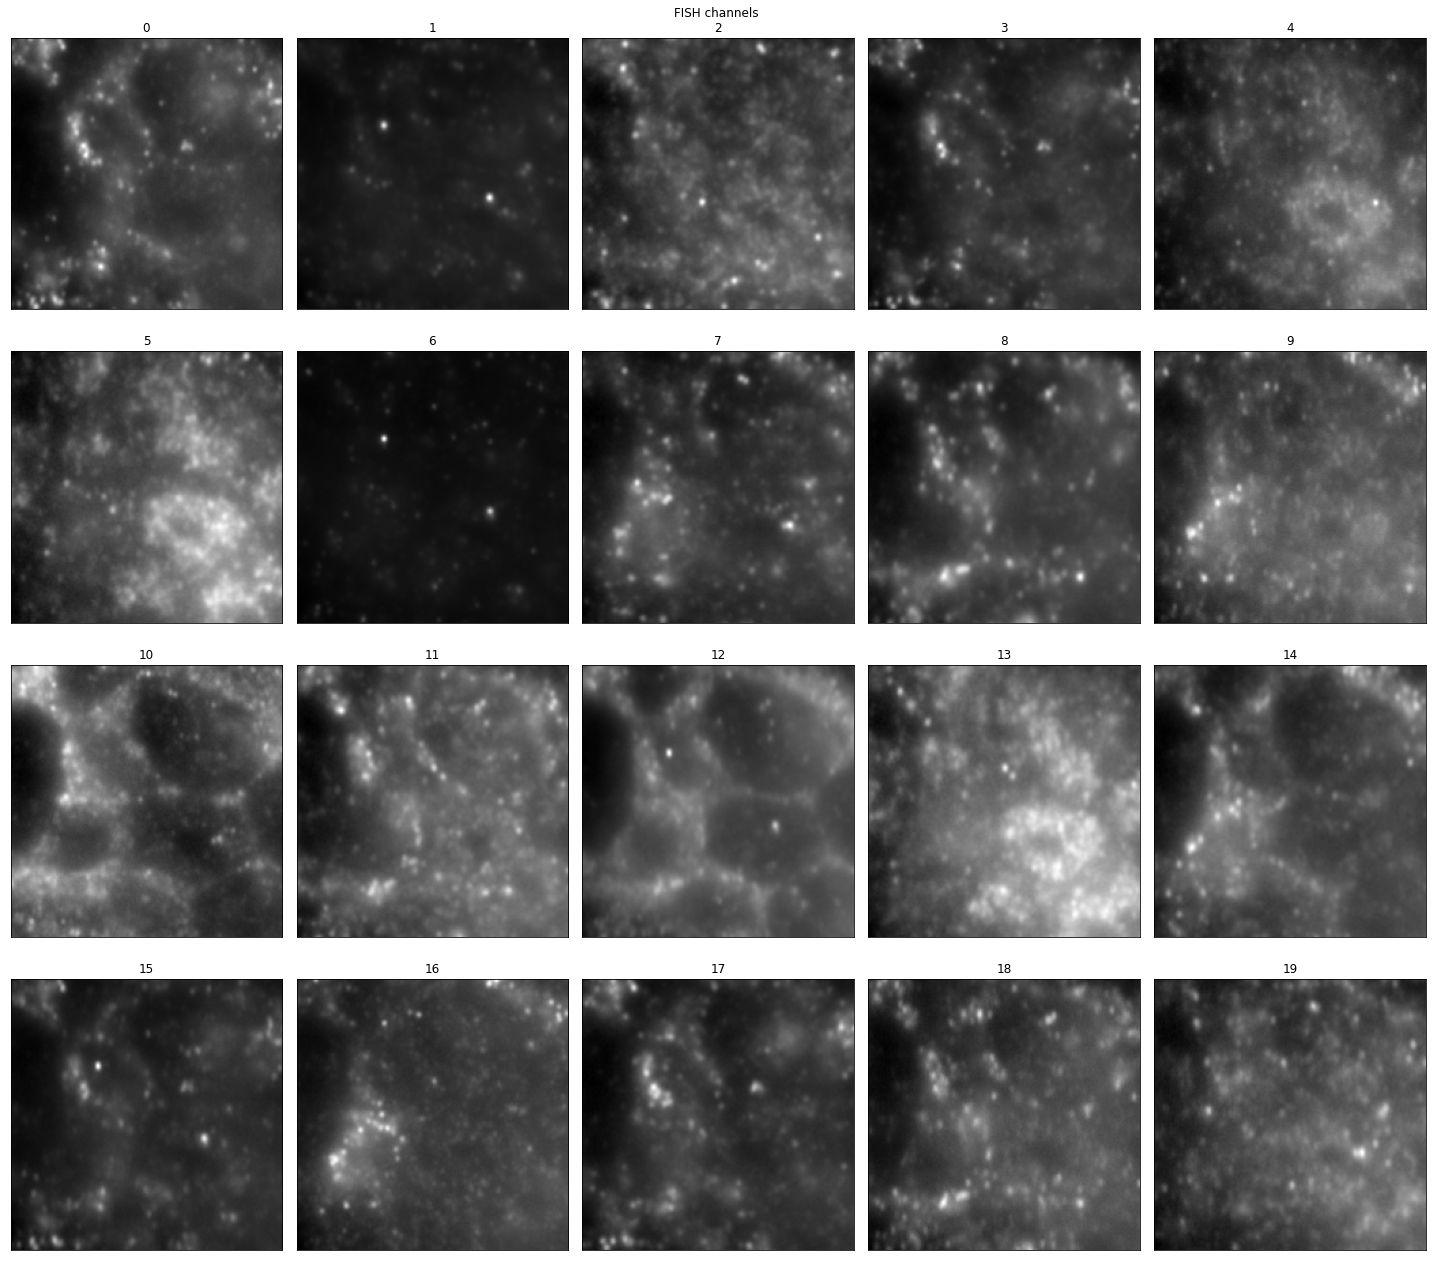

In [5]:
fig,ax = plt.subplots(4,5,figsize=(20, 18))

for idx, ax_d in enumerate(ax.flatten()):
    ax_d.imshow(spots_image[0,..., idx], cmap='gray')
    ax_d.set_title(idx)
    ax_d.set_xticks([])
    ax_d.set_yticks([])

plt.suptitle('FISH channels')
plt.tight_layout()

plt.show()

### mesmer segmentation

In [6]:
polaris_app = Polaris(image_type='multiplex', 
                      segmentation_type='mesmer',
                      decoding_kwargs={'r': r, 'c': c, 'df_barcodes': df_barcodes})

2022-11-22 21:43:12.133660: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2022-11-22 21:43:12.133737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-11-22 21:43:12.133985: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
spots_pred = polaris_app.predict(spots_image=spots_image,
                                 segmentation_image=mesmer_image,
                                 image_mpp=0.11, spots_clip=True, 
                                 spots_threshold=0.85,maxpool_extra_pixel_num=0)

/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [8]:
df_spots = spots_pred[0]
df_intensities = spots_pred[1]
segmentation_result = spots_pred[2]

In [9]:
df_spots

,x,y,batch_id,cell_id,probability,predicted_id,predicted_name
0,173,101,0,9,1.000000,49,Neat1
1,4,8,0,0,1.000000,7,Clca3b
2,100,62,0,8,0.999998,5,Txndc5
3,47,196,0,0,1.000000,4,Cps1
4,31,132,0,3,1.000000,7,Clca3b
...,...,...,...,...,...,...,...
689,74,191,0,0,0.991699,266,Background
690,139,105,0,7,0.611627,266,Background
691,163,78,0,9,0.999892,266,Background
692,78,134,0,3,0.998673,266,Background


In [10]:
df_intensities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.004006,0.970477,0.032967,0.005458,0.016271,0.081062,0.990560,0.001657,0.000492,0.244991,0.003515,0.004204,0.942368,0.002609,0.004320,0.984615,0.023134,0.000559,0.001327,0.001959
1,0.004904,0.002607,0.052352,0.005782,0.609850,0.015686,0.004434,0.001196,0.981123,0.000984,0.048113,0.971375,0.965831,0.006046,0.009624,0.000681,0.142274,0.004381,0.990013,0.335187
2,0.006572,0.000066,0.665722,0.004628,0.003085,0.008722,0.026424,0.930690,0.005723,0.986107,0.425388,0.416907,0.022639,0.002886,0.983854,0.039785,0.988909,0.005326,0.947687,0.059845
3,0.982878,0.007472,0.005436,0.988524,0.000744,0.005691,0.721145,0.065692,0.001936,0.001429,0.005021,0.004582,0.022074,0.000053,0.007021,0.985639,0.206520,0.857555,0.002711,0.001112
4,0.000369,0.000535,0.000782,0.000689,0.025621,0.179609,0.002340,0.006133,0.983361,0.006951,0.025265,0.988518,0.980061,0.516511,0.001676,0.001275,0.901251,0.000722,0.980401,0.018272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,0.073281,0.003308,0.003123,0.022077,0.854532,0.114974,0.000790,0.133669,0.001335,0.003119,0.236191,0.003706,0.009865,0.002307,0.005176,0.036361,0.000843,0.006555,0.002657,0.010783
690,0.000582,0.000800,0.002590,0.001059,0.803906,0.074403,0.001378,0.000164,0.000344,0.002655,0.000141,0.009444,0.003856,0.853138,0.001477,0.000339,0.005360,0.000209,0.006615,0.021146
691,0.001009,0.000395,0.392477,0.001211,0.852154,0.000671,0.000448,0.001359,0.001580,0.005431,0.000513,0.007780,0.007059,0.001205,0.005270,0.001164,0.000705,0.000471,0.001674,0.003911
692,0.010155,0.000804,0.006907,0.010301,0.009195,0.851709,0.000959,0.001430,0.000348,0.210085,0.002639,0.153469,0.000117,0.193642,0.002095,0.049017,0.002419,0.002924,0.012837,0.048433


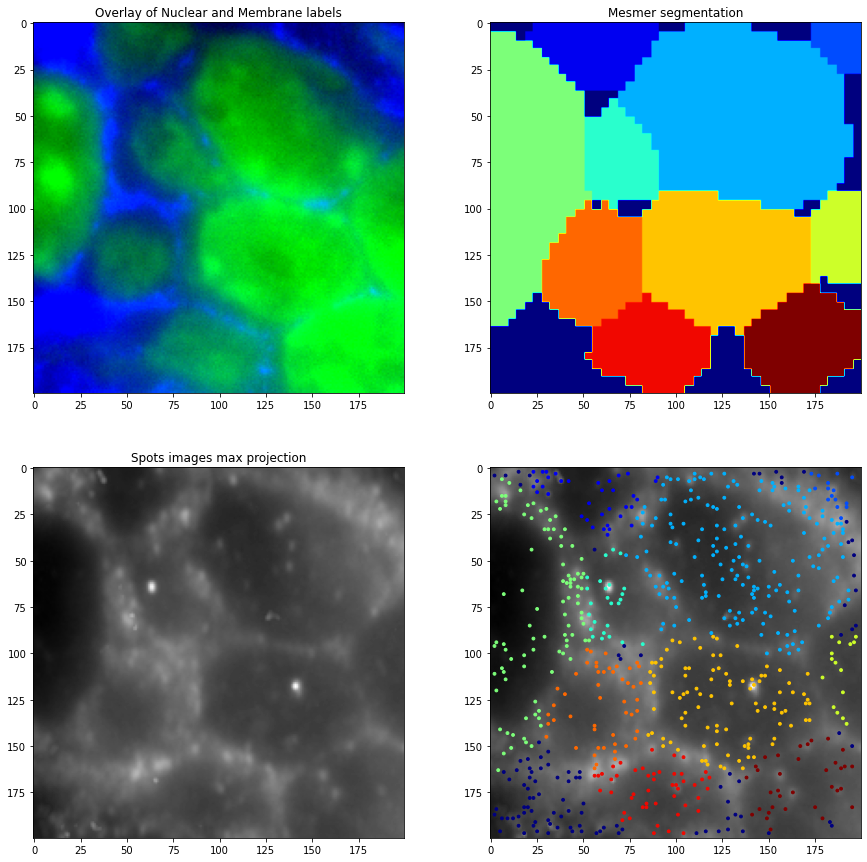

In [11]:
rgb_images = create_rgb_image(mesmer_image, channel_colors=['green', 'blue'])

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(rgb_images[0,...])
ax[0,0].set_title('Overlay of Nuclear and Membrane labels')
ax[0,1].imshow(segmentation_result[0,...,0],cmap='jet')
ax[0,1].set_title('Mesmer segmentation')
ax[1,0].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1,0].set_title('Spots images max projection')
ax[1,1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1,1].scatter(df_spots.y, df_spots.x, c=df_spots.cell_id, cmap='jet', s=8)

### No segmentation

In [12]:
polaris_app = Polaris(image_type='multiplex', 
                      segmentation_type='no segmentation',
                      decoding_kwargs={'r': r, 'c': c, 'df_barcodes': df_barcodes})

/usr/local/lib/python3.8/dist-packages/deepcell_spots/applications/polaris.py:180: UserWarning: No segmentation application instantiated.
  warnings.warn('No segmentation application instantiated.')


In [13]:
spots_pred = polaris_app.predict(spots_image=spots_image,
                                 spots_clip=True, spots_threshold=0.85,
                                 maxpool_extra_pixel_num=0)

In [14]:
df_spots = spots_pred[0]
df_intensities = spots_pred[1]

In [15]:
df_spots

,x,y,batch_id,cell_id,probability,predicted_id,predicted_name
0,173,101,0,None,1.000000,49,Neat1
1,4,8,0,None,1.000000,7,Clca3b
2,100,62,0,None,0.999998,5,Txndc5
3,47,196,0,None,1.000000,4,Cps1
4,31,132,0,None,1.000000,7,Clca3b
...,...,...,...,...,...,...,...
689,74,191,0,None,0.991699,266,Background
690,139,105,0,None,0.611627,266,Background
691,163,78,0,None,0.999892,266,Background
692,78,134,0,None,0.998673,266,Background


In [16]:
df_intensities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.004006,0.970477,0.032967,0.005458,0.016271,0.081062,0.990560,0.001657,0.000492,0.244991,0.003515,0.004204,0.942368,0.002609,0.004320,0.984615,0.023134,0.000559,0.001327,0.001959
1,0.004904,0.002607,0.052352,0.005782,0.609850,0.015686,0.004434,0.001196,0.981123,0.000984,0.048113,0.971375,0.965831,0.006046,0.009624,0.000681,0.142274,0.004381,0.990013,0.335187
2,0.006572,0.000066,0.665722,0.004628,0.003085,0.008722,0.026424,0.930690,0.005723,0.986107,0.425388,0.416907,0.022639,0.002886,0.983854,0.039785,0.988909,0.005326,0.947687,0.059845
3,0.982878,0.007472,0.005436,0.988524,0.000744,0.005691,0.721145,0.065692,0.001936,0.001429,0.005021,0.004582,0.022074,0.000053,0.007021,0.985639,0.206520,0.857555,0.002711,0.001112
4,0.000369,0.000535,0.000782,0.000689,0.025621,0.179609,0.002340,0.006133,0.983361,0.006951,0.025265,0.988518,0.980061,0.516511,0.001676,0.001275,0.901251,0.000722,0.980401,0.018272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,0.073281,0.003308,0.003123,0.022077,0.854532,0.114974,0.000790,0.133669,0.001335,0.003119,0.236191,0.003706,0.009865,0.002307,0.005176,0.036361,0.000843,0.006555,0.002657,0.010783
690,0.000582,0.000800,0.002590,0.001059,0.803906,0.074403,0.001378,0.000164,0.000344,0.002655,0.000141,0.009444,0.003856,0.853138,0.001477,0.000339,0.005360,0.000209,0.006615,0.021146
691,0.001009,0.000395,0.392477,0.001211,0.852154,0.000671,0.000448,0.001359,0.001580,0.005431,0.000513,0.007780,0.007059,0.001205,0.005270,0.001164,0.000705,0.000471,0.001674,0.003911
692,0.010155,0.000804,0.006907,0.010301,0.009195,0.851709,0.000959,0.001430,0.000348,0.210085,0.002639,0.153469,0.000117,0.193642,0.002095,0.049017,0.002419,0.002924,0.012837,0.048433


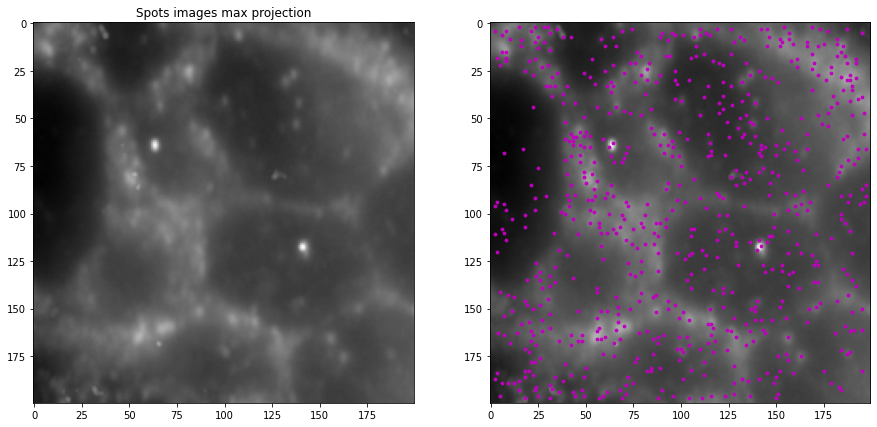

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[0].set_title('Spots images max projection')
ax[1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1].scatter(df_spots[df_spots.cell_id != 0].y, df_spots[df_spots.cell_id != 0].x, c='m', s=8)